In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from neuralforecast.models import LSTM

from src.data.loaders import CommodityLoader
from src.models.ensemble.dynamic_selection.dcs_la.dynamic_selection_by_local_accuracy import DCSLARegressor

from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score
)

import warnings
from sklearn.exceptions import UndefinedMetricWarning

In [42]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 
}
plt.rcParams.update(dark_style)
rcParams['figure.figsize'] = (18,7)

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [43]:
models = [
    # LGBMRegressor(
    #     n_estimators=1000, 
    #     learning_rate=0.1, 
    #     max_depth=10, 
    #     num_leaves=63, 
    #     min_child_samples=5, 
    #     reg_alpha=0, 
    #     reg_lambda=0.01, 
    #     random_state=42, 
    #     verbose=-1
    # ),
    # LSTM(
    #     h=1,
    #     input_size=1,
    #     encoder_n_layers=2,
    #     encoder_hidden_size=64,
    #     decoder_layers=2,
    #     decoder_hidden_size=32,
    #     max_steps=500,
    #     learning_rate=0.001,
    #     batch_size=32
    # ),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        max_depth=6, 
        objective='reg:squarederror'
    ),
    # KNeighborsRegressor(
    #     n_neighbors=5, 
    #     weights='distance'
    # ),
    MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        learning_rate_init=0.001, 
        max_iter=500, 
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=5, 
        min_samples_leaf=5, 
        max_depth=5
    ),
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
]

models_top_k_10 = [
    LGBMRegressor(
        n_estimators=1000, 
        learning_rate=0.1, 
        max_depth=10, 
        num_leaves=63, 
        min_child_samples=5, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        random_state=42, 
        verbose=-1
    ),
    # LSTM(
    #     h=1,
    #     input_size=12,
    #     encoder_n_layers=2,
    #     encoder_hidden_size=64,
    #     decoder_layers=2,
    #     decoder_hidden_size=32,
    #     max_steps=500,
    #     learning_rate=0.001,
    #     batch_size=32
    # ),
    XGBRegressor(
        n_estimators=50, 
        learning_rate=0.03125, 
        reg_alpha=0, 
        reg_lambda=0.01, 
        max_depth=6, 
        objective='reg:squarederror'
    ),
    # KNeighborsRegressor(
    #     n_neighbors=5, 
    #     weights='distance'
    # ),
    MLPRegressor(
        hidden_layer_sizes=(64, 32), 
        activation='relu', 
        solver='adam', 
        learning_rate_init=0.001, 
        max_iter=500, 
        random_state=42
    ),
    RandomForestRegressor(
        n_estimators=5, 
        min_samples_leaf=5, 
        max_depth=5
    ),
    SVR(
        C=10.0,
        gamma=0.5,
        epsilon=0.25
    )
]

In [44]:
df_brl = CommodityLoader.load_all_commodities(currency='BRL', preprocessing=True, monthly_aggregation='mean', limit_date=None)

ദ്ദി・ᴗ・)✧ acucar_santos carregado com sucesso
ദ്ദി・ᴗ・)✧ acucar_sp carregado com sucesso
ദ്ദി・ᴗ・)✧ algodao carregado com sucesso
ദ്ദി・ᴗ・)✧ arroz carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_arabica carregado com sucesso
ദ്ദി・ᴗ・)✧ cafe_robusta carregado com sucesso
ദ്ദി・ᴗ・)✧ milho carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ soja_paranagua carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_parana carregado com sucesso
ദ്ദി・ᴗ・)✧ trigo_rs carregado com sucesso


In [45]:
df_brl['unique_id'].unique()

series_test_sizes = {
    "ACUCAR_SANTOS": 20,
    "ACUCAR_SP": 80,
    "ALGODAO": 105,
    "ARROZ": 72,
    "CAFE_ARABICA": 104,
    "CAFE_ROBUSTA": 87,
    "MILHO": 75,
    "SOJA_PARANA": 101,
    "SOJA_PARANAGUA": 70,
    "TRIGO_PARANA": 77,
    "TRIGO_RS": 77
}


=== Série: ACUCAR_SANTOS ===

=== Série: ACUCAR_SANTOS (horizon=20) ===


RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
Random

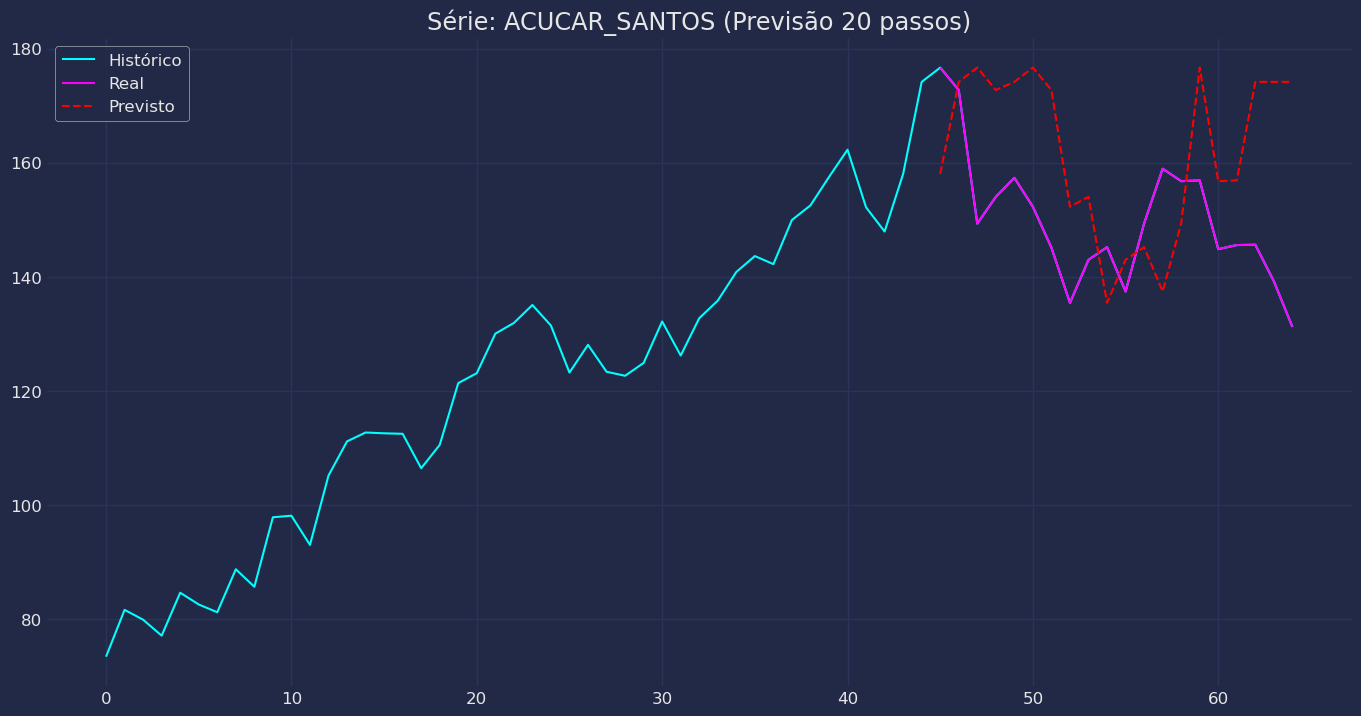


=== Série: ACUCAR_SP ===

=== Série: ACUCAR_SP (horizon=80) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForest

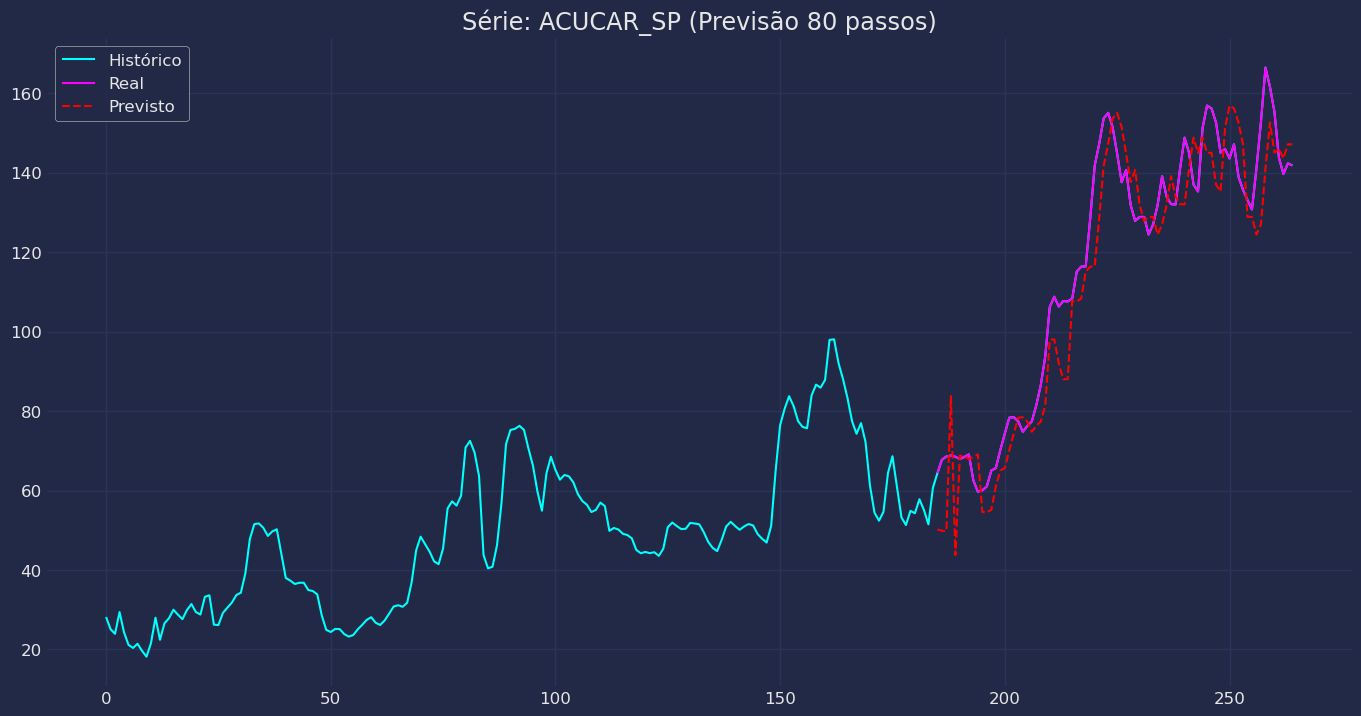


=== Série: ALGODAO ===

=== Série: ALGODAO (horizon=105) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, m

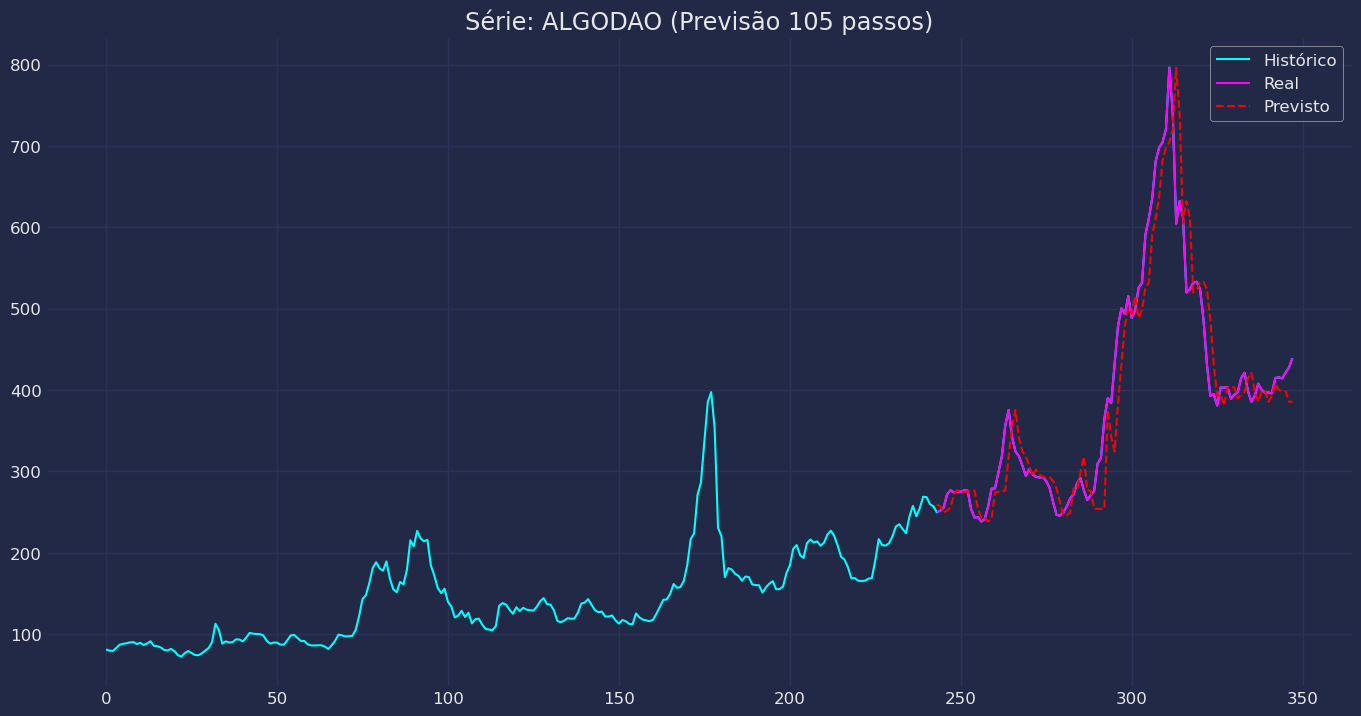


=== Série: ARROZ ===

=== Série: ARROZ (horizon=72) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegresso

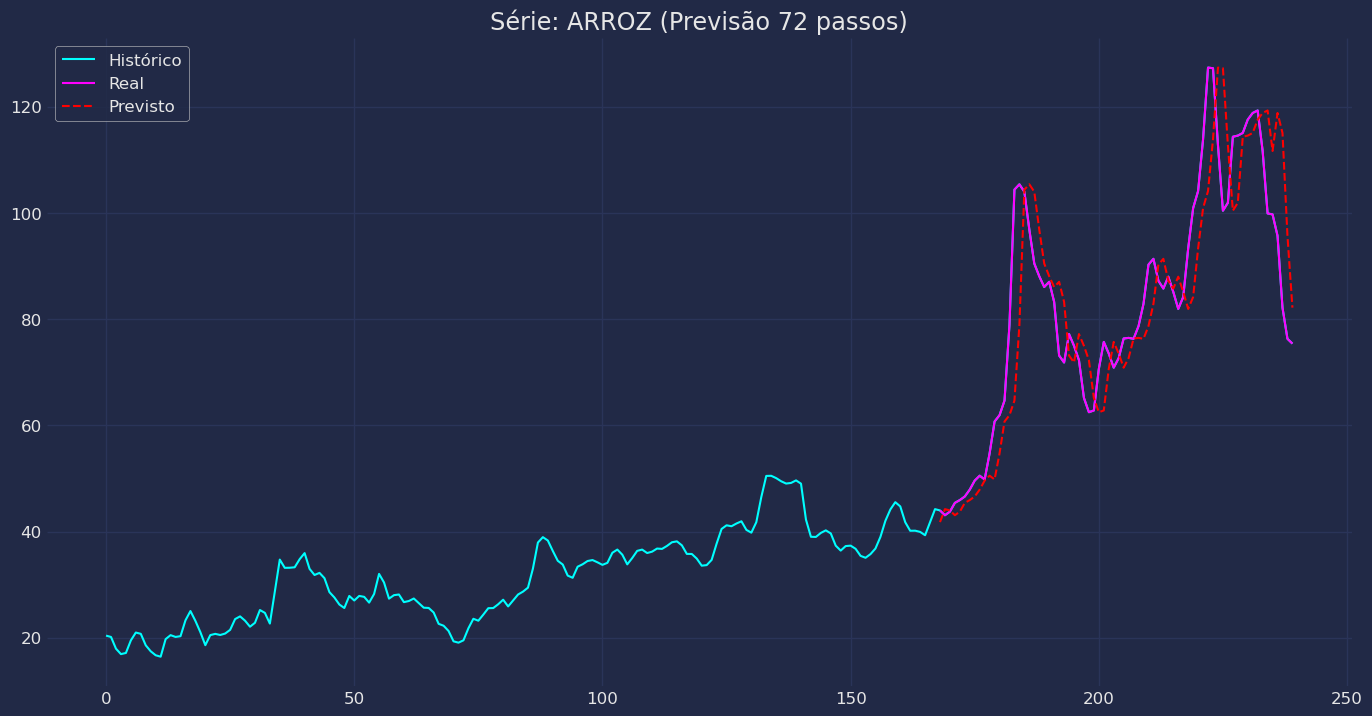


=== Série: CAFE_ARABICA ===

=== Série: CAFE_ARABICA (horizon=104) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)

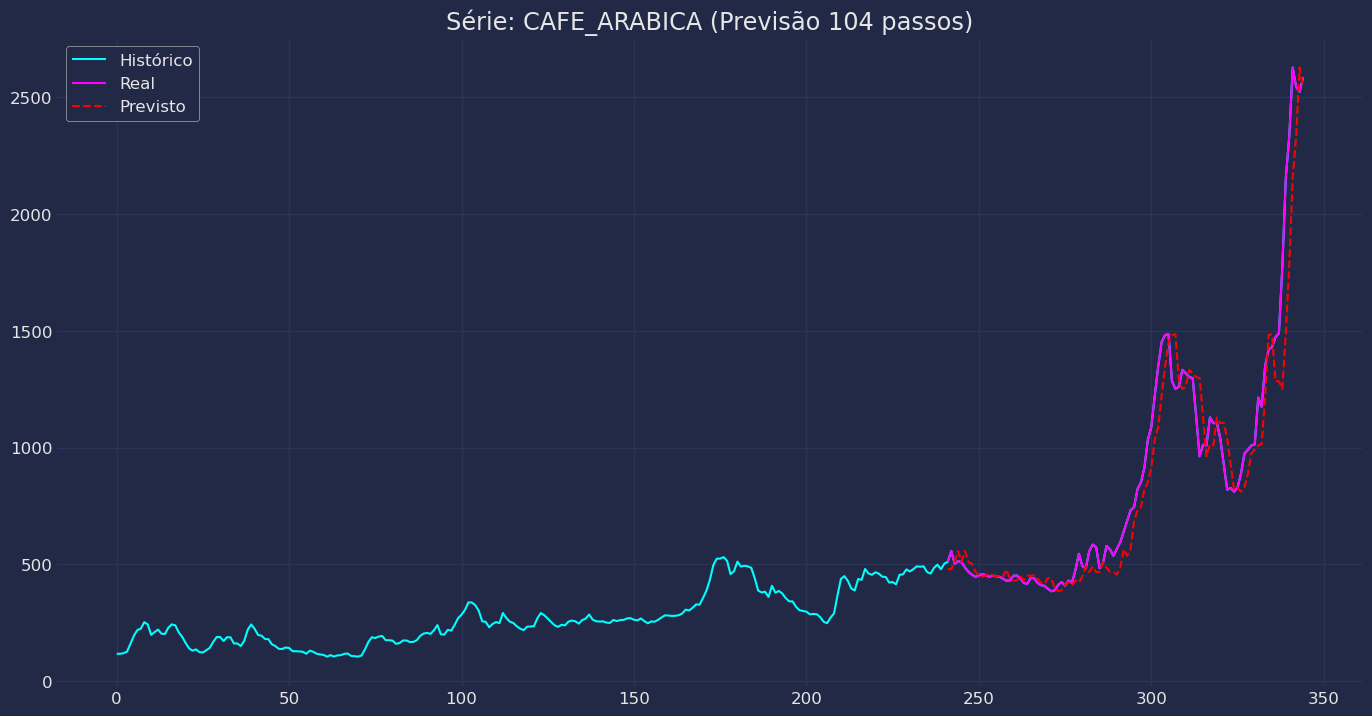


=== Série: CAFE_ROBUSTA ===

=== Série: CAFE_ROBUSTA (horizon=87) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
Random

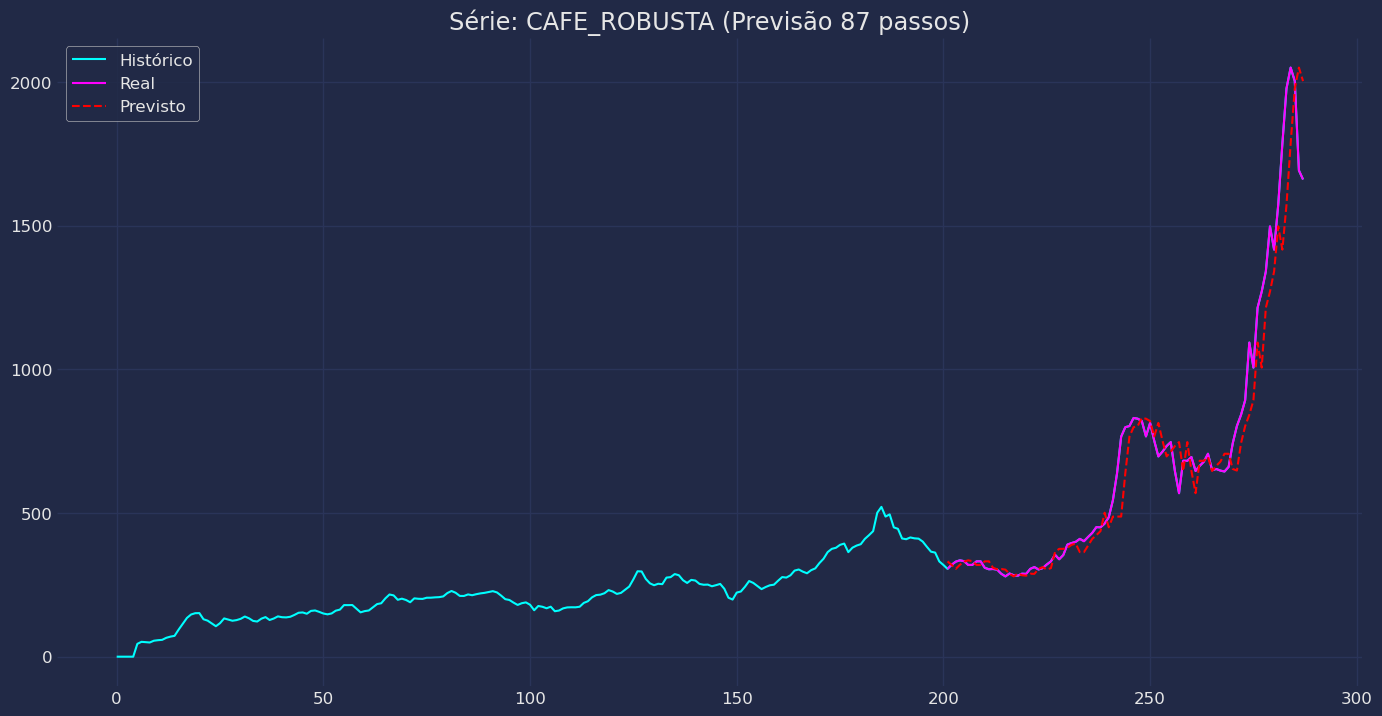


=== Série: MILHO ===

=== Série: MILHO (horizon=75) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegresso

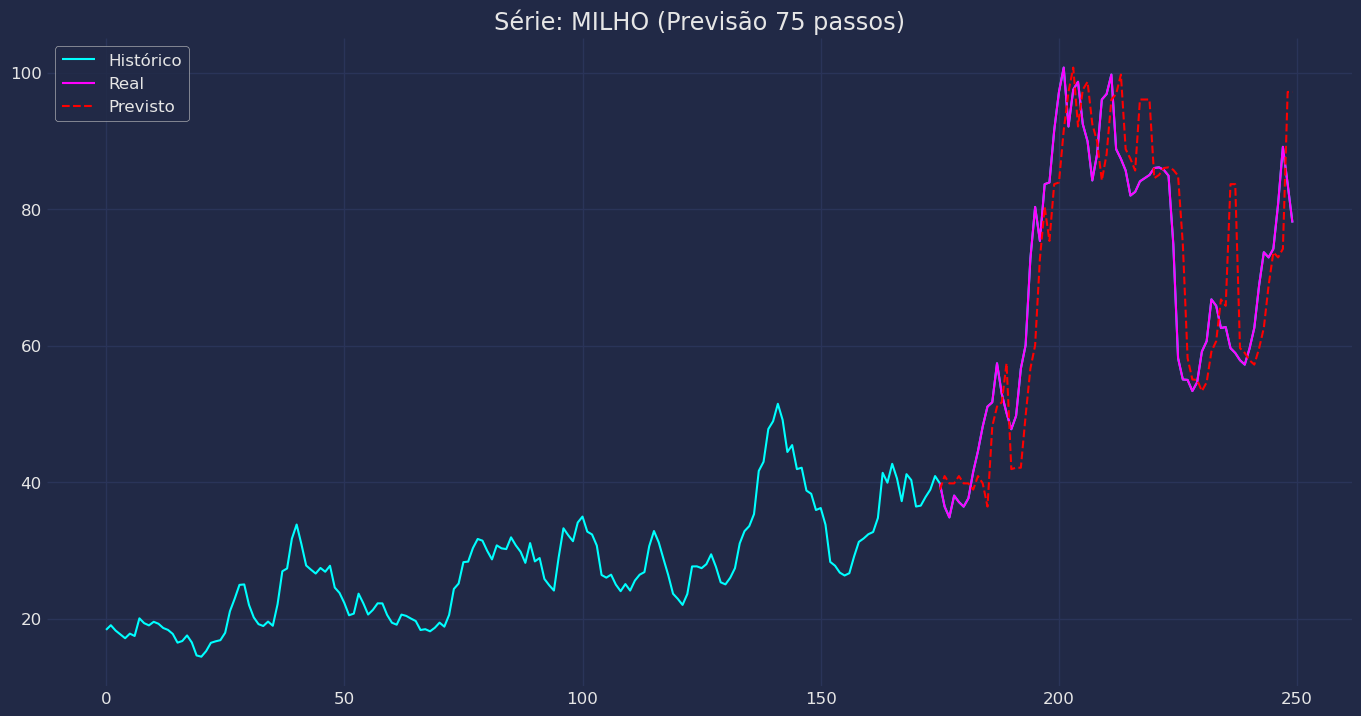


=== Série: SOJA_PARANA ===

=== Série: SOJA_PARANA (horizon=101) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5

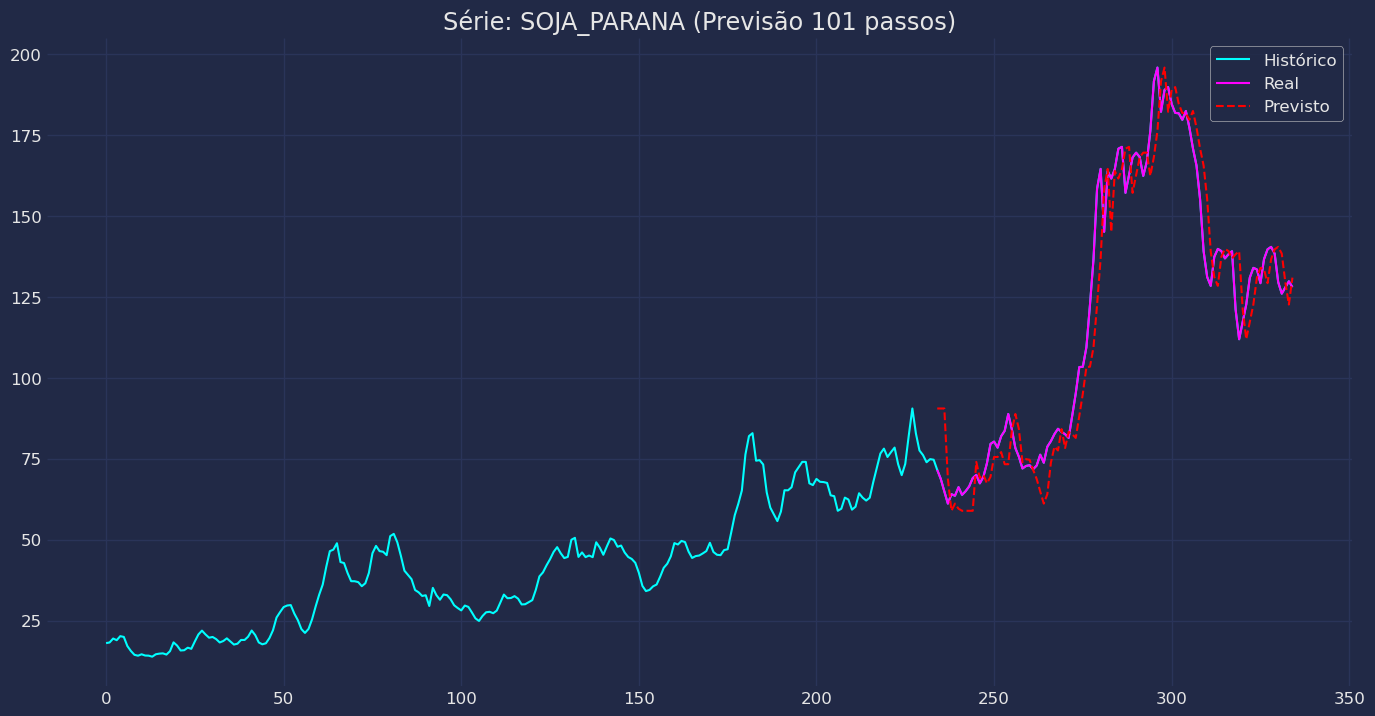


=== Série: SOJA_PARANAGUA ===

=== Série: SOJA_PARANAGUA (horizon=70) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
Ra

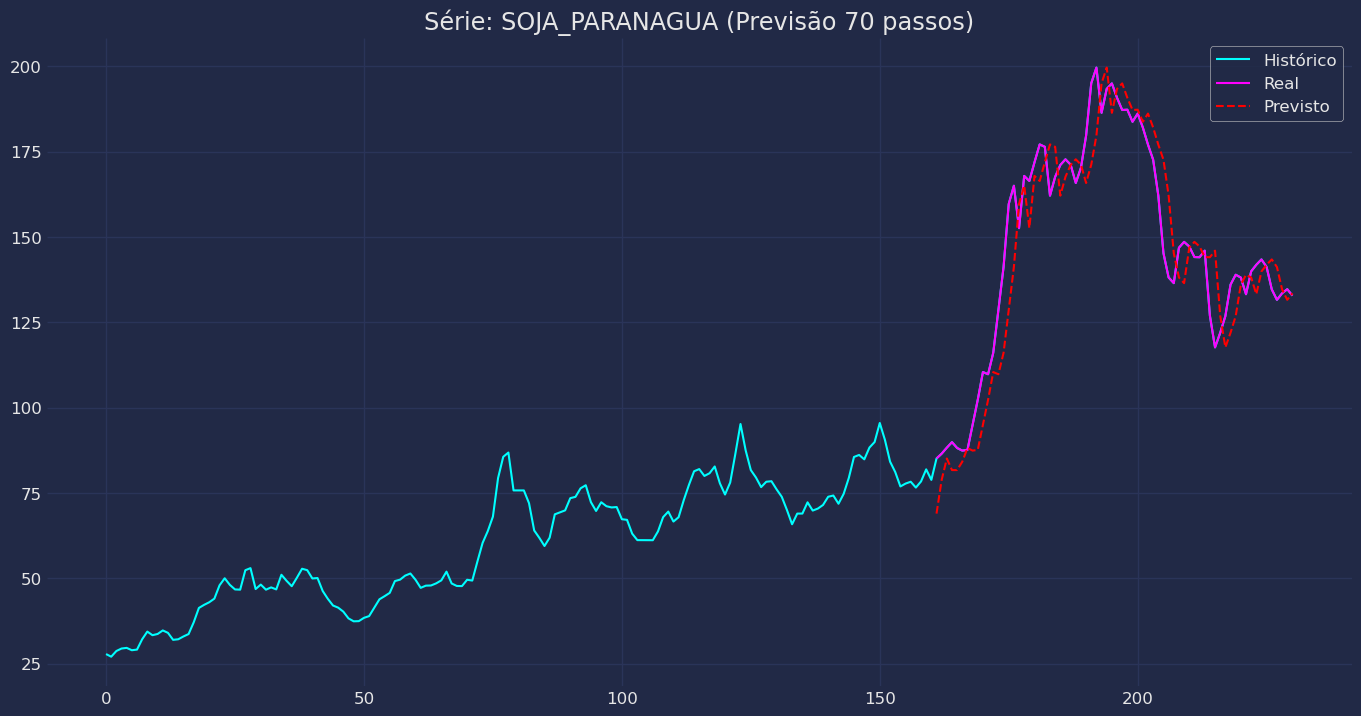


=== Série: TRIGO_PARANA ===

=== Série: TRIGO_PARANA (horizon=77) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)


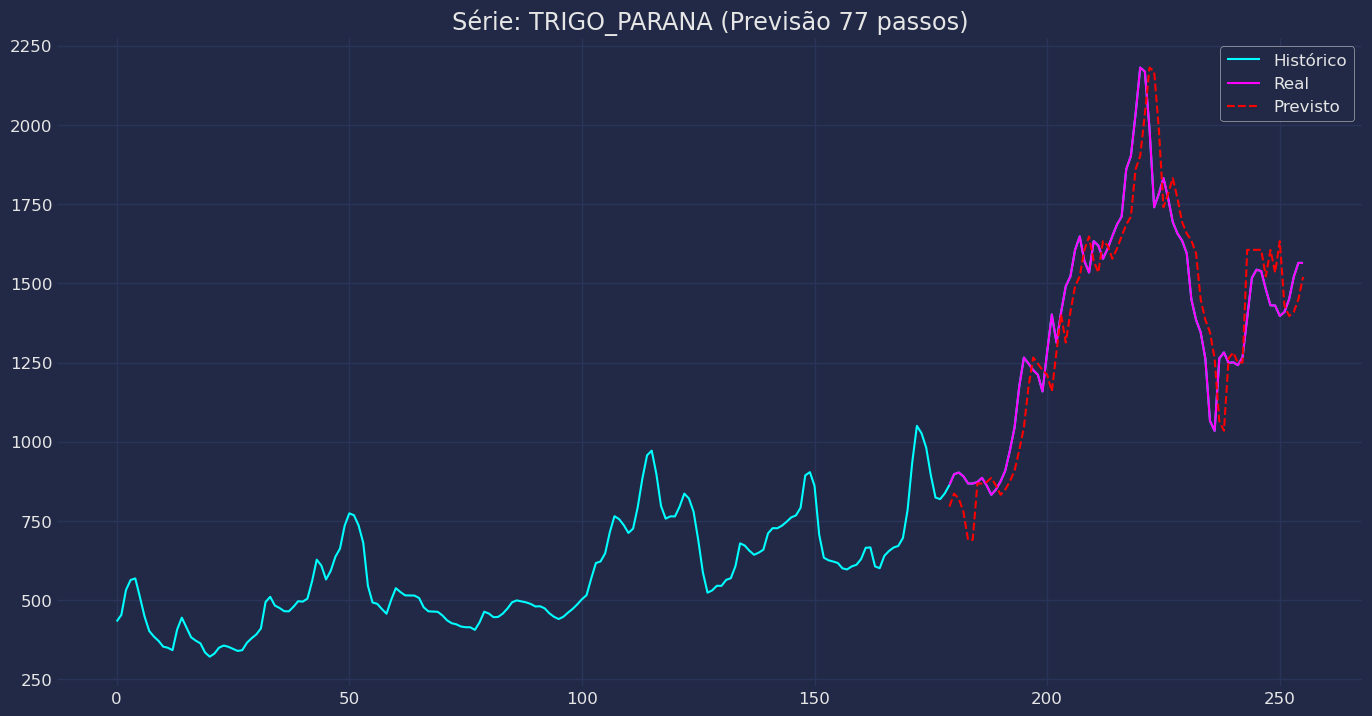


=== Série: TRIGO_RS ===

=== Série: TRIGO_RS (horizon=77) ===
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRegressor(max_depth=5, min_samples_leaf=5, n_estimators=5)
RandomForestRe

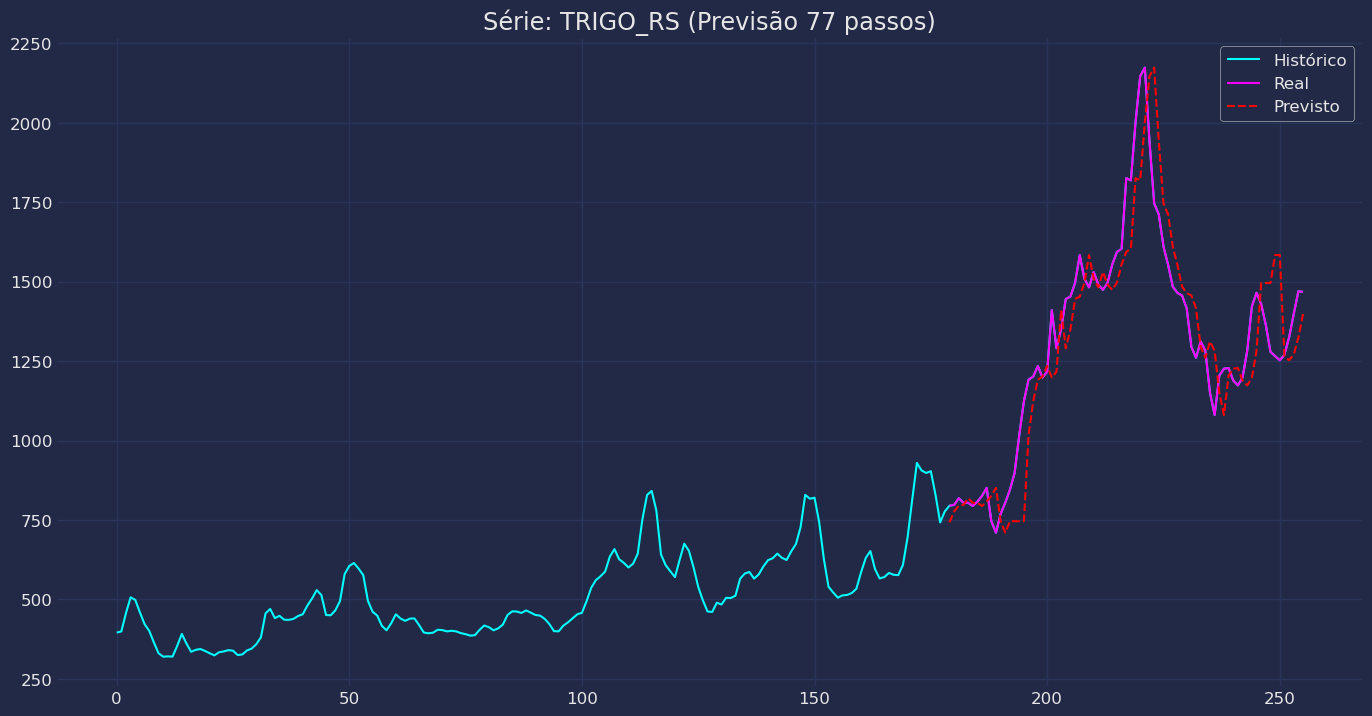


Resumo das métricas:
         unique_id           mse        rmse         mae      mape
0    ACUCAR_SANTOS    434.832410   20.852636   18.035092  0.122794
1        ACUCAR_SP    120.251660   10.965932    8.945321  0.082591
2          ALGODAO   1971.695963   44.403783   29.707387  0.071825
3            ARROZ    136.630729   11.688915    8.437984  0.096762
4     CAFE_ARABICA  22622.467272  150.407670   94.745415  0.095038
5     CAFE_ROBUSTA  13058.642260  114.274416   67.322645  0.079468
6            MILHO     91.204575    9.550109    7.421844  0.110653
7      SOJA_PARANA    133.985058   11.575191    8.896801  0.080410
8   SOJA_PARANAGUA    139.698252   11.819402    9.158846  0.065375
9     TRIGO_PARANA  18734.434252  136.873789  109.567566  0.080202
10        TRIGO_RS  21539.455055  146.763262  111.668179  0.084294


In [46]:
dcs = DCSLARegressor(models, top_k=1, similarity='euclidean')

results = []

for uid in df_brl['unique_id'].unique():
    print(f"\n=== Série: {uid} ===")

    horizon = series_test_sizes.get(uid)
    print(f"\n=== Série: {uid} (horizon={horizon}) ===")
    y_series = df_brl[df_brl['unique_id'] == uid]['y'].values
    forecast, y_real_future = dcs.predict(y_series, horizon=horizon)

    mse = mean_squared_error(y_real_future, forecast)
    rmse = root_mean_squared_error(y_real_future, forecast)
    mae = mean_absolute_error(y_real_future, forecast)
    mape = mean_absolute_percentage_error(y_real_future, forecast)

    results.append({
        "unique_id": uid,
        "horizon": horizon,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "y_real_future": y_real_future,
        "forecast": forecast
    })

    print("Valores reais:    ", np.round(y_real_future, 2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

    # plotar série inteira
    plt.figure(figsize=(15, 8))
    plt.plot(y_series, label="Histórico", color="cyan")
    plt.plot(range(len(y_series)-horizon, len(y_series)), y_real_future, label="Real", color="fuchsia")
    plt.plot(range(len(y_series)-horizon, len(y_series)), forecast, label="Previsto", color="red", linestyle="--")
    plt.title(f"Série: {uid} (Previsão {horizon} passos)")
    plt.legend()
    plt.show()

# Converter resultados em DataFrame para análise geral
df_results = pd.DataFrame(results)
print("\nResumo das métricas:")
print(df_results[["unique_id", "mse", "rmse", "mae", "mape"]])

In [47]:
for model in dcs.history_errors:
    print("############### Model ###############")
    print(model)
    print("Error history:")
    print(dcs.history_errors.get(model))
    print("Times used:")
    print(len(dcs.history_errors.get(model)))

############### Model ###############
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
Error history:
[3.01261904761904, 0.9588888888889073, 4.877222222222201, 11.573452380952375, 6.022000000000006, 11.570227272727266, 13.820833333333326, 146.0247368421053]
Times used:
8
############### Model #######


=== Série: ACUCAR_SANTOS ===

=== Série: ACUCAR_SANTOS (horizon=20) ===
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsampl

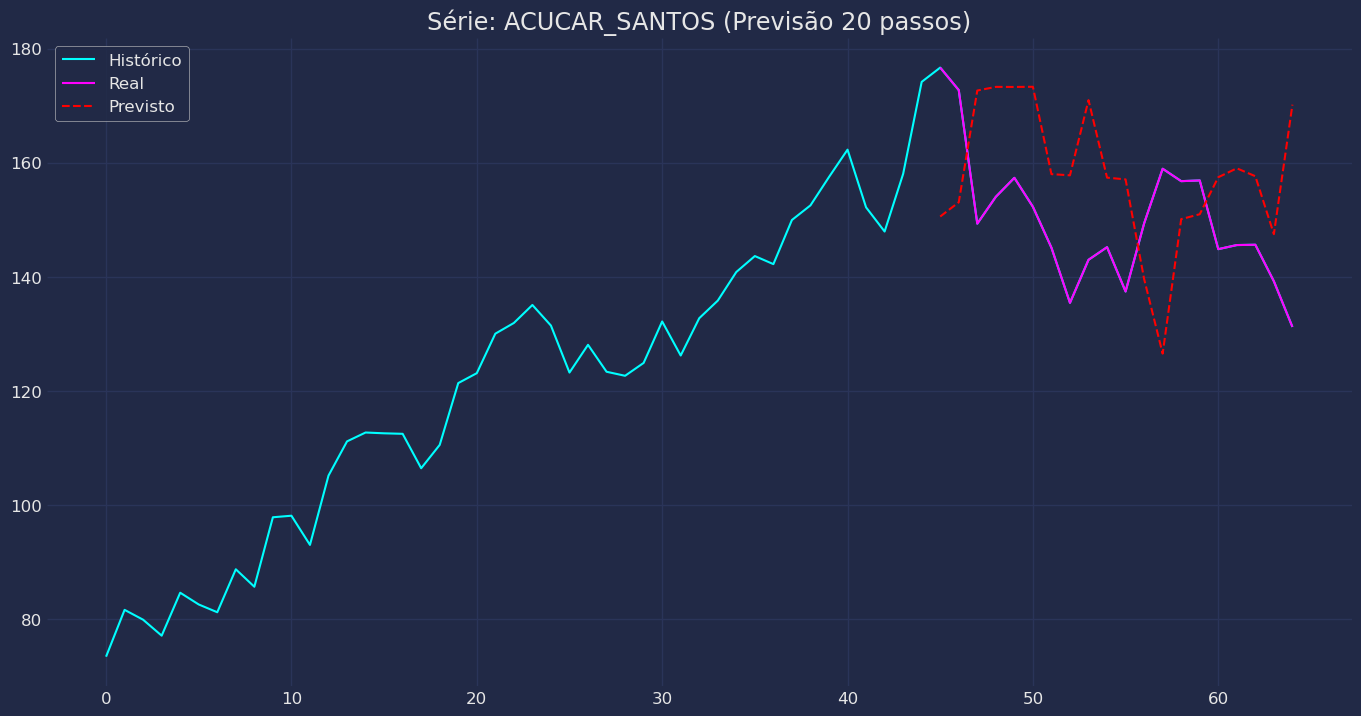


=== Série: ACUCAR_SP ===

=== Série: ACUCAR_SP (horizon=80) ===
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=No

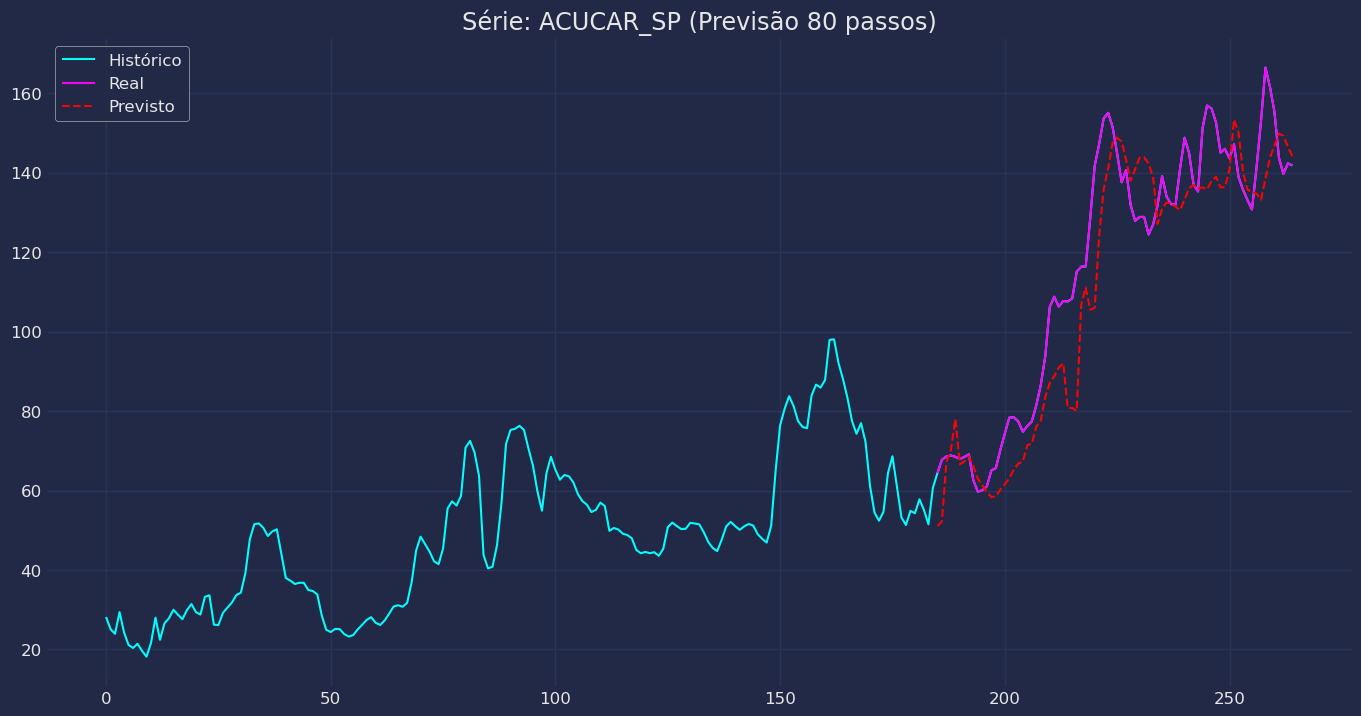


=== Série: ALGODAO ===

=== Série: ALGODAO (horizon=105) ===
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds

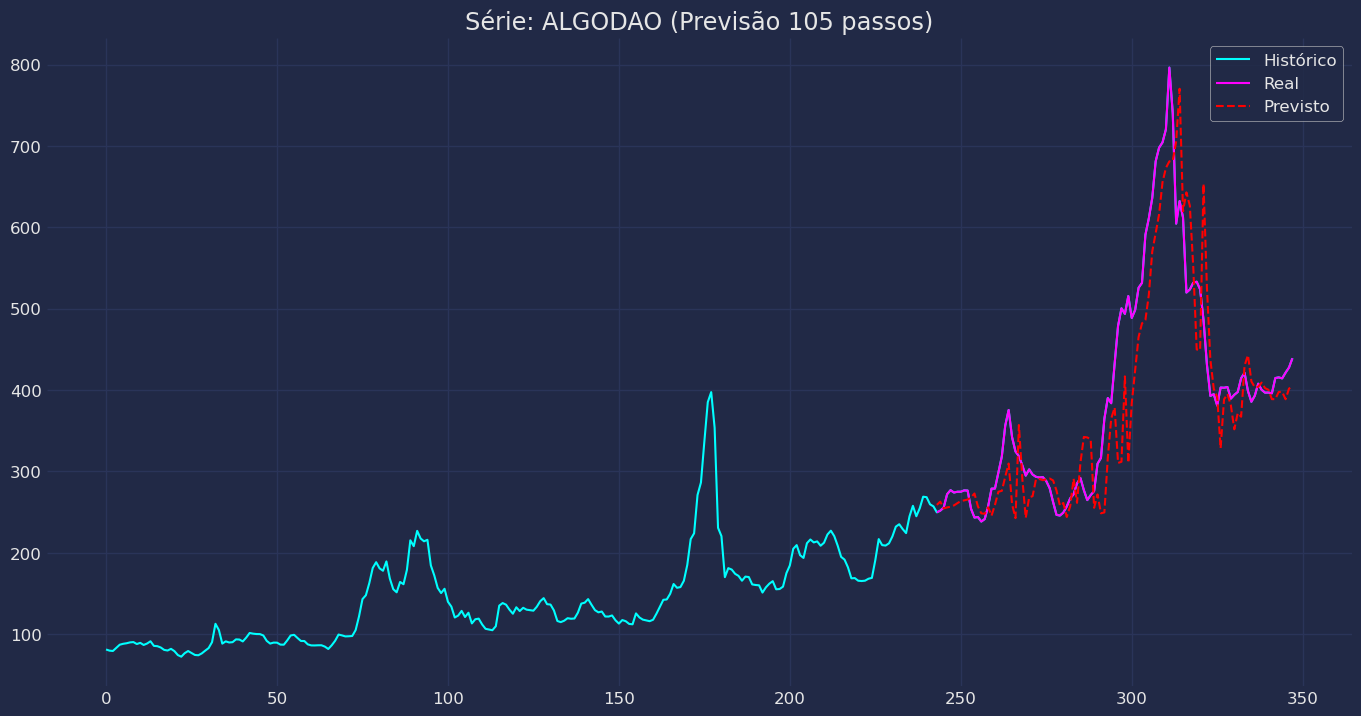


=== Série: ARROZ ===

=== Série: ARROZ (horizon=72) ===
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=n

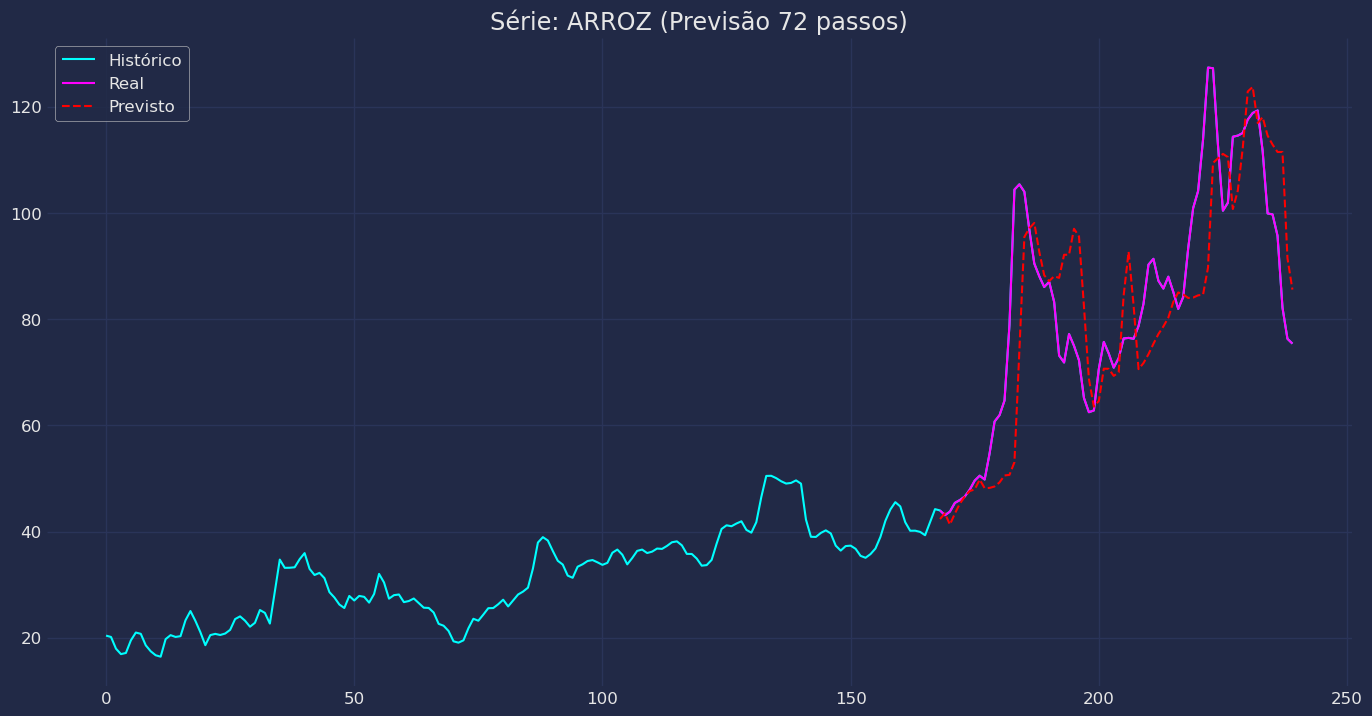


=== Série: CAFE_ARABICA ===

=== Série: CAFE_ARABICA (horizon=104) ===
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopp

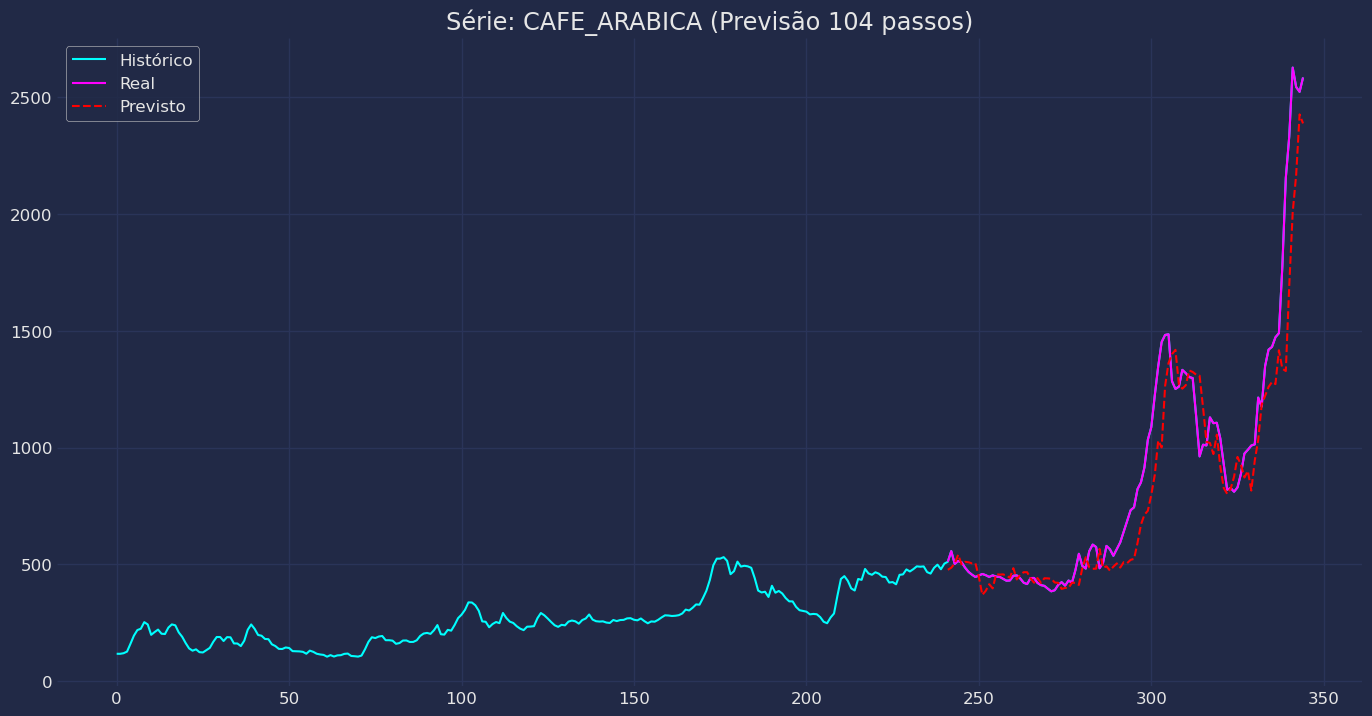


=== Série: CAFE_ROBUSTA ===

=== Série: CAFE_ROBUSTA (horizon=87) ===
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
      

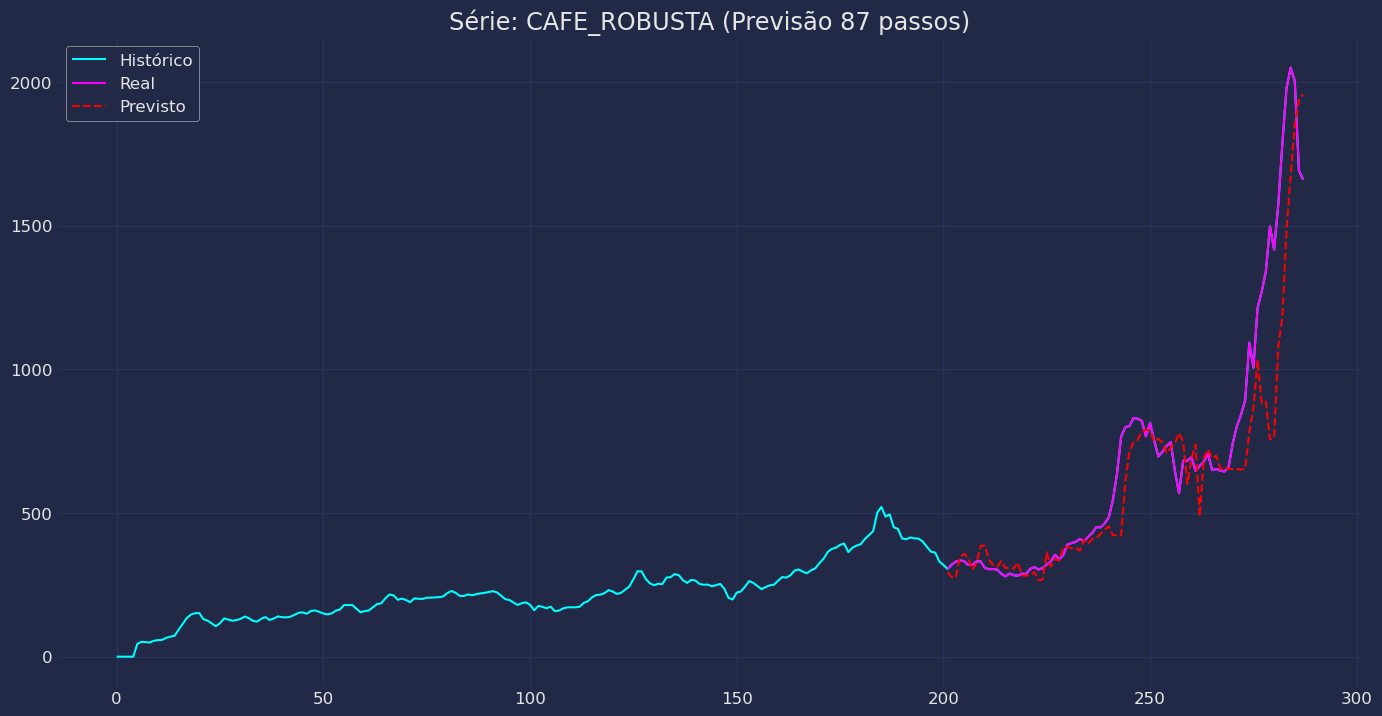


=== Série: MILHO ===

=== Série: MILHO (horizon=75) ===
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random

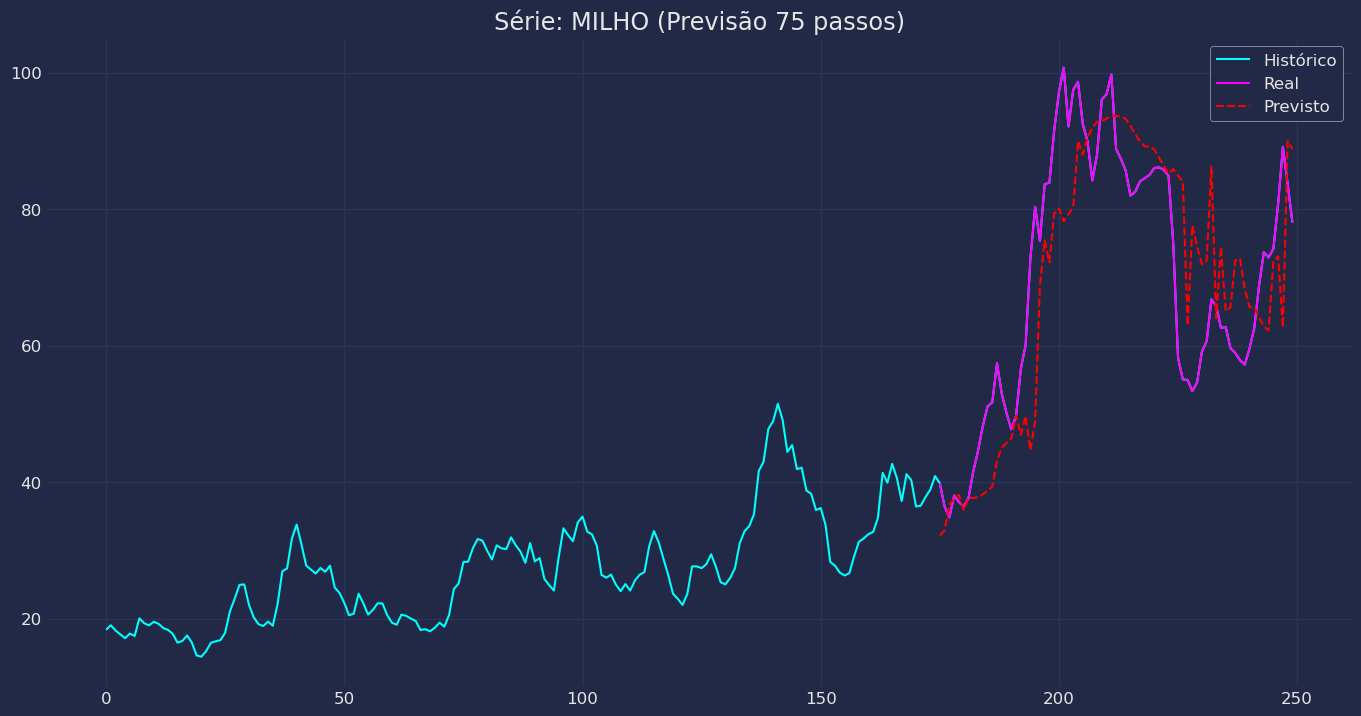


=== Série: SOJA_PARANA ===

=== Série: SOJA_PARANA (horizon=101) ===
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
MLPRe

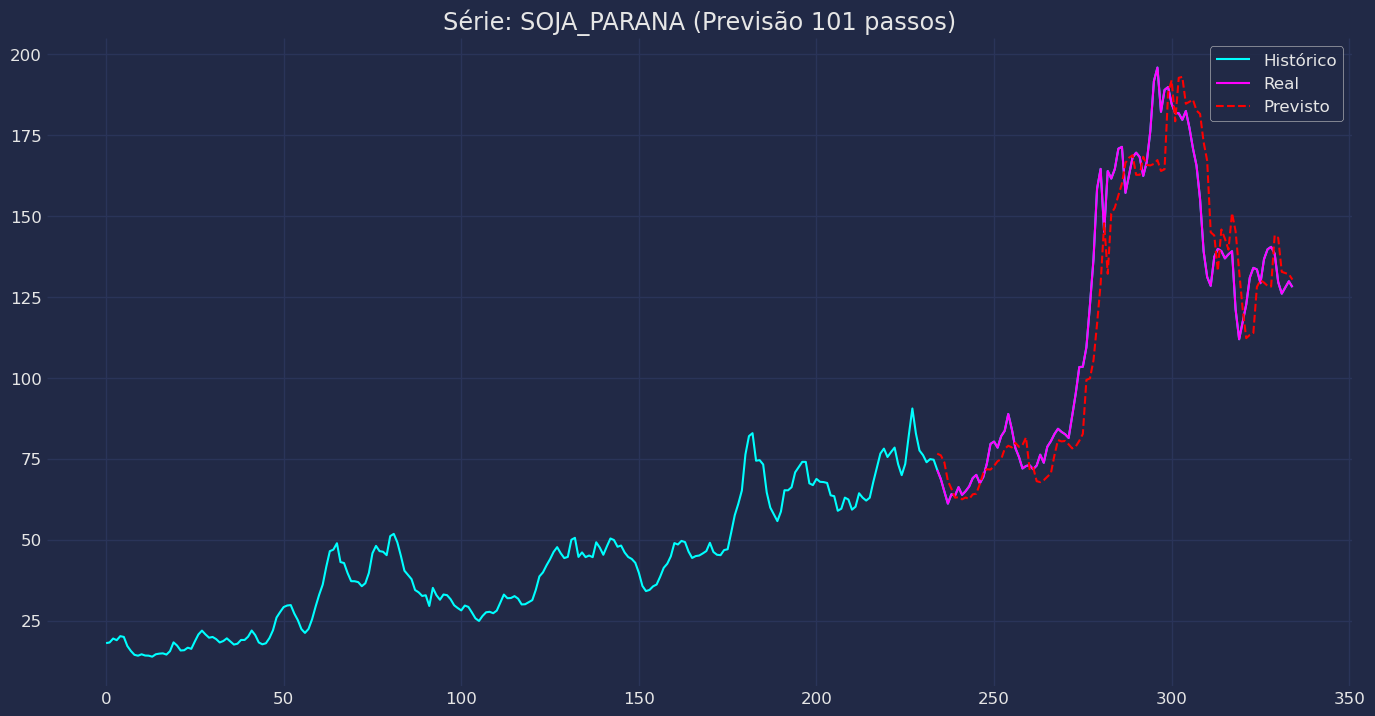


=== Série: SOJA_PARANAGUA ===

=== Série: SOJA_PARANAGUA (horizon=70) ===
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
SVR(C=10.0, epsilon=0.25, gamma=0.5)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max

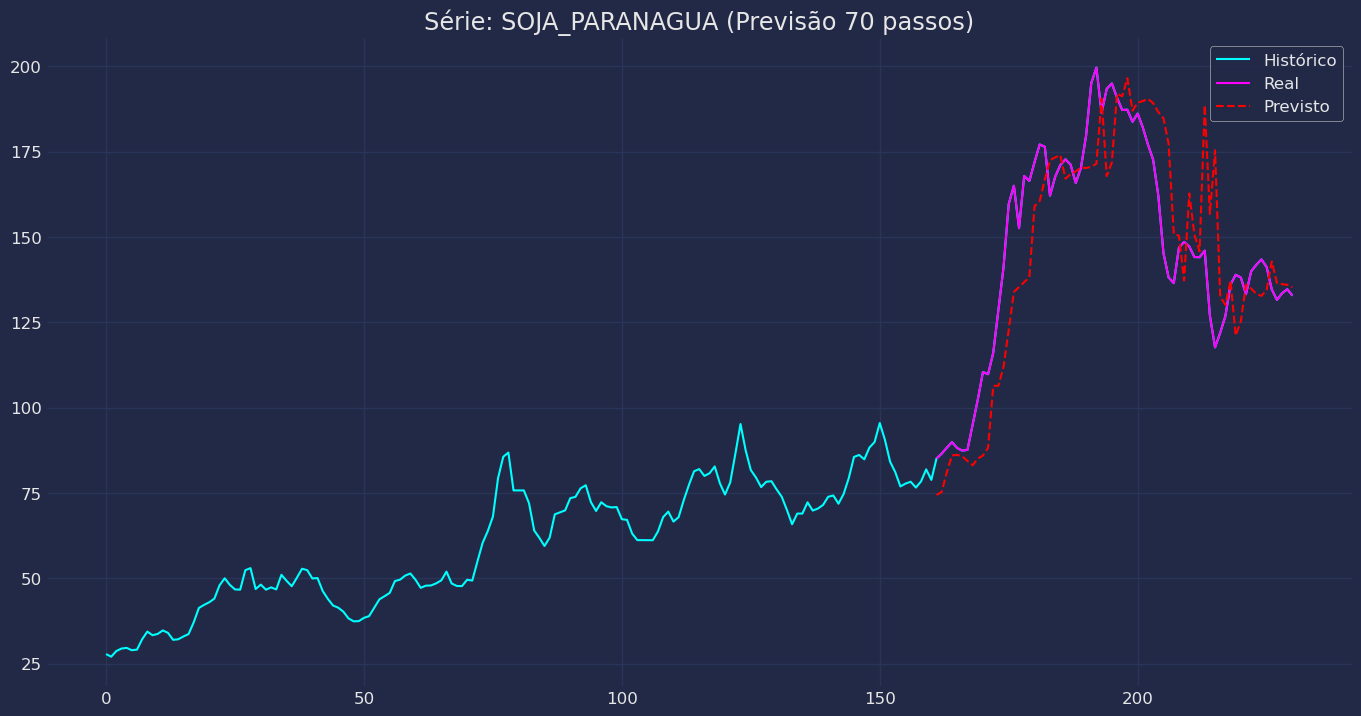


=== Série: TRIGO_PARANA ===

=== Série: TRIGO_PARANA (horizon=77) ===
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num_parallel_tree=None, ...)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stoppi

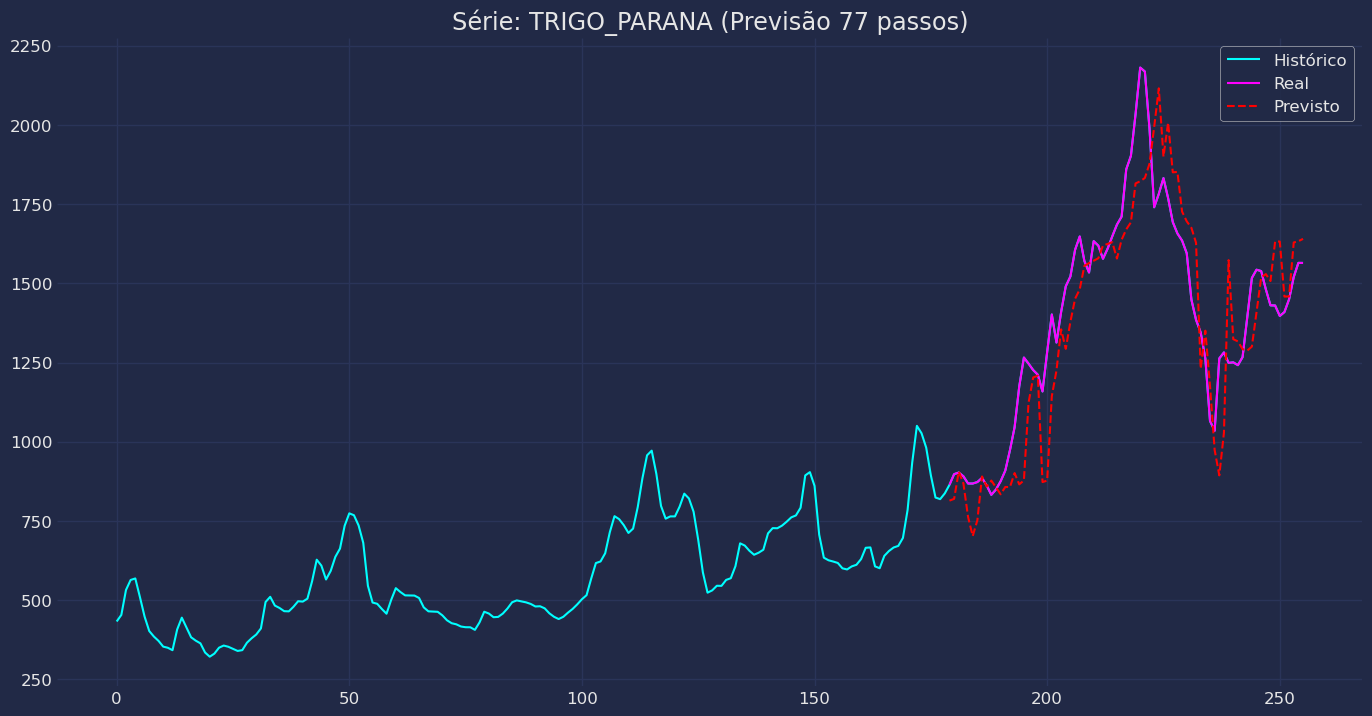


=== Série: TRIGO_RS ===

=== Série: TRIGO_RS (horizon=77) ===
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             i

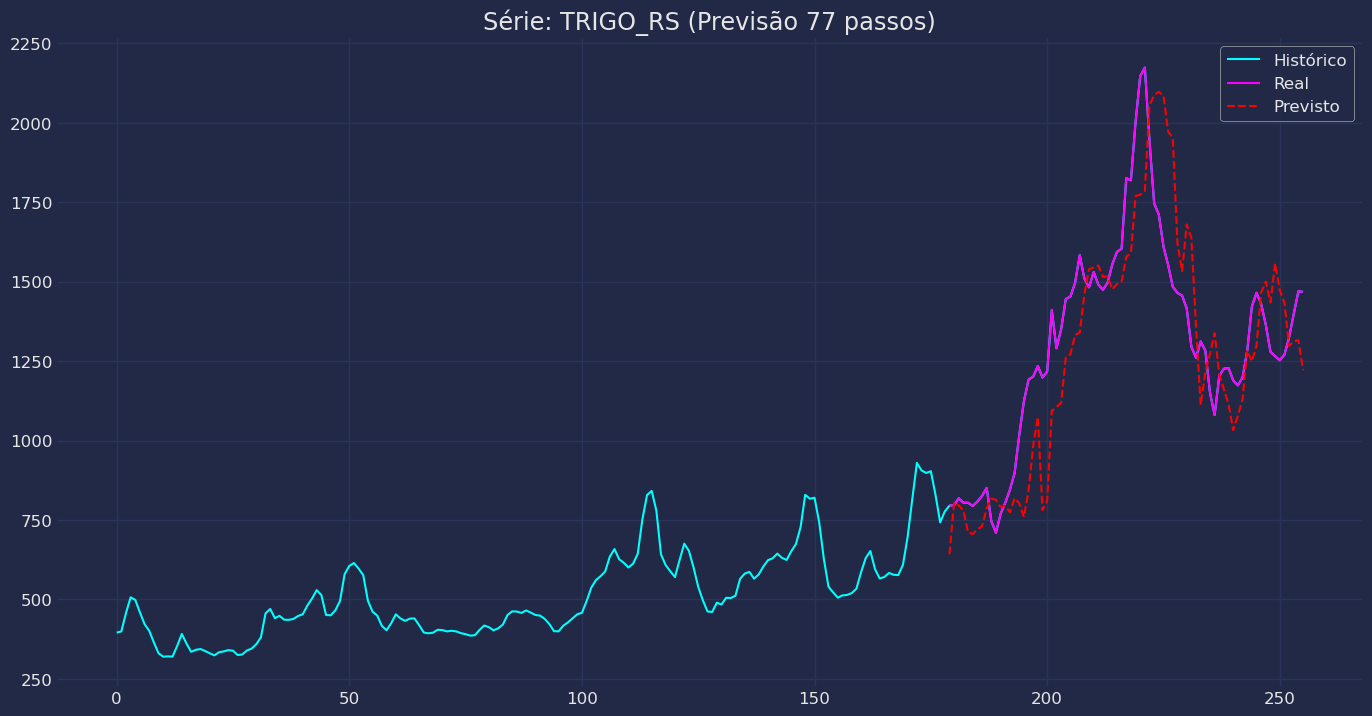


Resumo das métricas:
         unique_id           mse        rmse         mae      mape
0    ACUCAR_SANTOS    397.834552   19.945790   18.019134  0.121300
1        ACUCAR_SP    172.279962   13.125546   10.379710  0.091445
2          ALGODAO   3821.085997   61.814933   44.387654  0.105868
3            ARROZ    202.022823   14.213473   10.318539  0.119521
4     CAFE_ARABICA  33076.248762  181.868768  115.444659  0.115970
5     CAFE_ROBUSTA  36256.000800  190.410086  108.489515  0.123744
6            MILHO    138.628737   11.774071    9.127125  0.136003
7      SOJA_PARANA    184.493359   13.582833   10.061425  0.081737
8   SOJA_PARANAGUA    329.409383   18.149639   13.567516  0.095281
9     TRIGO_PARANA  28477.723379  168.753440  131.556541  0.094158
10        TRIGO_RS  42922.116328  207.176534  165.933901  0.124402


In [48]:
dcs = DCSLARegressor(models_top_k_10, top_k=10, similarity='euclidean')

results = []

for uid in df_brl['unique_id'].unique():
    print(f"\n=== Série: {uid} ===")

    horizon = series_test_sizes.get(uid)
    print(f"\n=== Série: {uid} (horizon={horizon}) ===")
    y_series = df_brl[df_brl['unique_id'] == uid]['y'].values
    forecast, y_real_future = dcs.predict(y_series, horizon=horizon)

    mse = mean_squared_error(y_real_future, forecast)
    rmse = root_mean_squared_error(y_real_future, forecast)
    mae = mean_absolute_error(y_real_future, forecast)
    mape = mean_absolute_percentage_error(y_real_future, forecast)

    results.append({
        "unique_id": uid,
        "horizon": horizon,
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "mape": mape,
        "y_real_future": y_real_future,
        "forecast": forecast
    })

    print("Valores reais:    ", np.round(y_real_future, 2).tolist())
    print("Valores previstos:", np.round(forecast, 2).tolist())
    print(f"MSE: {mse:.2f} | RMSE: {rmse:.2f} | MAE: {mae:.2f} | MAPE: {mape:.2f}%")

    # plotar série inteira
    plt.figure(figsize=(15, 8))
    plt.plot(y_series, label="Histórico", color="cyan")
    plt.plot(range(len(y_series)-horizon, len(y_series)), y_real_future, label="Real", color="fuchsia")
    plt.plot(range(len(y_series)-horizon, len(y_series)), forecast, label="Previsto", color="red", linestyle="--")
    plt.title(f"Série: {uid} (Previsão {horizon} passos)")
    plt.legend()
    plt.show()

# Converter resultados em DataFrame para análise geral
df_results = pd.DataFrame(results)
print("\nResumo das métricas:")
print(df_results[["unique_id", "mse", "rmse", "mae", "mape"]])

In [49]:
for model in dcs.history_errors:
    print("############### Model ###############")
    print(model)
    print("Error history:")
    print(dcs.history_errors.get(model))
    print("Times used:")
    print(len(dcs.history_errors.get(model)))

############### Model ###############
LGBMRegressor(max_depth=10, min_child_samples=5, n_estimators=1000,
              num_leaves=63, random_state=42, reg_alpha=0, reg_lambda=0.01,
              verbose=-1)
Error history:
[]
Times used:
0
############### Model ###############
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.03125, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50,
             n_jobs=None, num

-- top_k sendo 10 (10 janelas mais próximas)
-- top_k sendo 1 (1 janelas mais próximas)


-- aumentar o pool


-- implementar DSNAW